# Training NeuralODEs

In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchdiffeq import odeint, odeint_adjoint

from dynamics.lorenz import lorenz_derivative
from dynamics.limit_cycle import wilson_cowan_derivative
from dynamics.spp import spp_derivative

from models.tools import get_batch, JupyterLossPlotCallback,\
    train_model
from models.neuralnets import create_mlp, MLP_NeuralODE

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## The Lorenz System

Let's start by trying to fit the Lorenz system.

In [3]:
from dynamics.lorenz import lorenz_derivative

t_span = (0.,26.)
num_timepoints = 10000
num_samples = 32
# samples x state-dimension
initial_states = 20.*np.random.rand(num_samples, 3) - 10.
t_eval = np.linspace(t_span[0], t_span[1], num_timepoints)
method = 'RK45'
# samples x state-dimension x timepoints
samples = np.zeros((*initial_states.shape, num_timepoints))

for sample_idx in range(num_samples):
    samples[sample_idx,...] = solve_ivp(
        lorenz_derivative,
        t_span=t_span,
        y0=initial_states[sample_idx,...],
        t_eval=t_eval,
        method=method).y


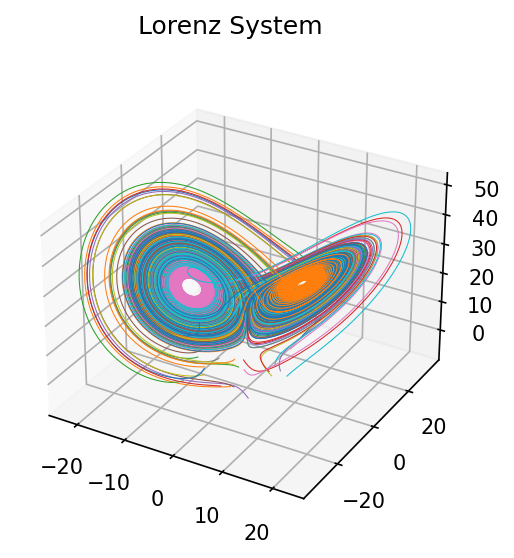

In [4]:
def plot_3d_path(ax, states, color='blue', lw=0.5, **plot_kwargs):
    xs, ys, zs = states
    plot_kwargs['color'] = color
    plot_kwargs['lw'] = lw
    ax.plot(xs, ys, zs, **plot_kwargs)
    return ax

fig = plt.figure(figsize=(6,4), dpi=150)
ax = plt.axes(projection='3d')
fig.add_subplot(ax)

for sample_idx in range(num_samples):
    plot_3d_path(
        ax, samples[sample_idx,...],
        color=f"C{sample_idx}")
ax.set_title("Lorenz System");

In [7]:
from models.tools import JupyterLossPlotCallback, train_model

num_training_samples = int(samples.shape[0]*0.8)
training_data = samples[:num_training_samples,...]
validation_data = samples[-num_training_samples:,...]

node = MLP_NeuralODE(state_dimensions=3,hidden_layers=[20,20])
optimizer = torch.optim.RMSprop(node.parameters(), lr=1e-3)
plot_callback = JupyterLossPlotCallback(plot_every_n=10)
callbacks = [plot_callback]

training_steps = 5000
batch_size = 256
batch_timesteps = 100
node, optimizer, losses, validation_losses = train_model(
    node, optimizer,
    training_data=training_data,
    training_t_eval=t_eval,
    validation_data=validation_data,
    validation_t_eval=t_eval,
    training_steps=training_steps,
    batch_size=batch_size,
    batch_timesteps=batch_timesteps,
    callbacks=callbacks,
    # losses=losses,
    # validation_losses=validation_losses
)

In [10]:
with torch.no_grad():
    estimated_traj = odeint_adjoint(
        node,
        torch.from_numpy(initial_states).to(device),
        torch.from_numpy(t_eval).to(device)).permute(1,2,0)

estimated_traj_numpy = estimated_traj.cpu().numpy()

In [10]:
fig = plt.figure(figsize=(6,4), dpi=150)
ax = plt.axes(projection='3d')
fig.add_subplot(ax)

for sample_idx in range(num_samples):
    plot_3d_path(
        ax, estimated_traj_numpy[sample_idx,...],
        color=f"C{sample_idx}")
ax.set_title("Estimated Lorenz System");

## Wilson-Cowan System

This system has a limit cycle attractor, and thus each trajectory is eventually the same.

In [11]:
# get data, same timespan as before because why not
t_span = (0.,26.)
num_timepoints = 10000
num_samples = 20
# samples x state-dimension
wc_initial_states = np.random.rand(num_samples, 2)
t_eval = np.linspace(t_span[0], t_span[1], num_timepoints)
method = 'RK45'
# samples x state-dimension x timepoints
wc_samples = np.zeros((*wc_initial_states.shape, num_timepoints))

for sample_idx in range(num_samples):
    wc_samples[sample_idx,...] = solve_ivp(
        wilson_cowan_derivative,
        t_span=t_span,
        y0=wc_initial_states[sample_idx,...],
        t_eval=t_eval,
        method=method).y

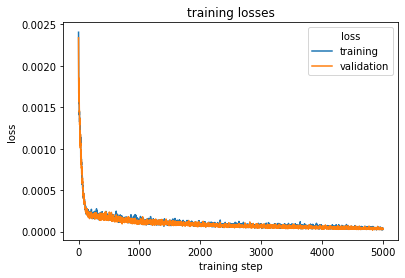

In [16]:
num_training_samples = int(wc_samples.shape[0]*0.8)
wc_training_data = wc_samples[:num_training_samples,...]
wc_validation_data = wc_samples[-num_training_samples:,...]

wc_node = MLP_NeuralODE(state_dimensions=2, hidden_layers=[16,16])
wc_optimizer = torch.optim.RMSprop(wc_node.parameters(), lr=1e-3)

training_steps = 5000
batch_size = 256
batch_timesteps = 100

plot_callback = JupyterLossPlotCallback(plot_every_n=50)
callbacks = [plot_callback]

wc_node, optimizer, wc_losses, wc_validation_losses = train_model(
    wc_node, wc_optimizer,
    training_data=wc_training_data,
    training_t_eval=t_eval,
    validation_data=wc_validation_data,
    validation_t_eval=t_eval,
    training_steps=training_steps,
    batch_size=batch_size,
    batch_timesteps=batch_timesteps,
    callbacks=callbacks,
    # losses=wc_losses,
    # validation_losses=wc_validation_losses
)

In [35]:
sample_ids = [0,1]

with torch.no_grad():
    estimated_traj = odeint_adjoint(
        wc_node,
        torch.from_numpy(
            # initial_states[-num_training_samples:,...]
            wc_initial_states[sample_ids,...]
        ).to(device),
        torch.from_numpy(t_eval).to(device)).permute(1,2,0)
estimated_traj_numpy = estimated_traj.cpu().numpy()

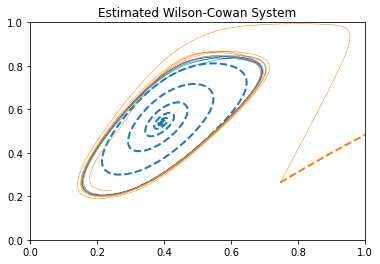

In [37]:
for sample_idx in range(
    min(2,estimated_traj_numpy.shape[0])
):
    plt.plot(
        wc_samples[sample_ids[sample_idx],0,:],
        wc_samples[sample_ids[sample_idx],1,:],
        color='C'+str(sample_idx),
        label='ground truth',
        lw=0.5)
    plt.plot(
        estimated_traj_numpy[sample_idx,0,:],
        estimated_traj_numpy[sample_idx,1,:],
        color='C'+str(sample_idx),
        label='model estimate',
        lw=2, ls='--')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.title("Estimated Wilson-Cowan System");

## Self-Propelled Particles

In [43]:
from tqdm.notebook import tqdm

num_samples = 64
num_timepoints = 5000
t_span = (0., 26.)
t_eval = np.linspace(t_span[0], t_span[1], 5000)

num_individuals = 5
state_dimensions = (4, num_individuals)
spp_initial_states = np.random.randn(
    num_samples, *state_dimensions).reshape(num_samples, -1)
method = 'RK45'
spp_samples = np.zeros((*spp_initial_states.shape, num_timepoints))

# solve_ivp assumes that states are vectors
vector_spp_derivative = lambda t,state: spp_derivative(
    t, state, 
    boundary_push=False,
    normalised=True,
    ).reshape(-1)

for sample_idx in tqdm(range(num_samples)):
    spp_samples[sample_idx,...] = solve_ivp(
        vector_spp_derivative,
        t_span=t_span,
        y0=spp_initials_states[sample_idx,...],
        t_eval=t_eval,
        method=method).y

# Original dimensions should be fine for everything else
spp_samples = spp_samples.reshape(num_samples, *state_dimensions, -1)

  0%|          | 0/64 [00:00<?, ?it/s]

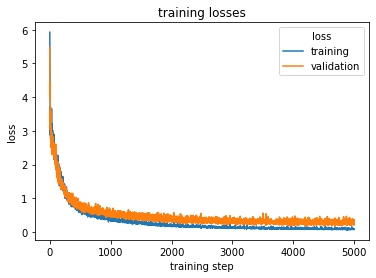

In [80]:
num_training_samples = int(spp_samples.shape[0]*0.8)
spp_training_data = spp_samples[:num_training_samples,...]
spp_validation_data = spp_samples[-num_training_samples:,...]

spp_node = MLP_NeuralODE(
    state_dimensions=state_dimensions,
    hidden_layers=[128,128,128])
spp_optimizer = torch.optim.RMSprop(
    spp_node.parameters(), lr=1e-3)

training_steps = 5000
batch_size = 256
batch_timesteps = 100

plot_callback = JupyterLossPlotCallback(plot_every_n=25)
callbacks = [plot_callback]

spp_node, optimizer, spp_losses, spp_validation_losses = train_model(
    spp_node, spp_optimizer,
    training_data=spp_training_data,
    training_t_eval=t_eval,
    validation_data=spp_validation_data,
    validation_t_eval=t_eval,
    training_steps=training_steps,
    batch_size=batch_size,
    batch_timesteps=batch_timesteps,
    callbacks=callbacks,
    # losses=spp_losses,
    # validation_losses=spp_validation_losses
)

In [105]:
from models.tools import _cycle_dimensions

sample_id = 10

with torch.no_grad():
    estimated_traj = odeint_adjoint(
        spp_node,
        torch.from_numpy(
            # initial_states[-num_training_samples:,...]
            spp_initial_states.reshape(-1, *state_dimensions)[sample_id,...]
        ).to(device),
        torch.from_numpy(t_eval).to(device))
estimated_traj = _cycle_dimensions(estimated_traj)
estimated_traj_numpy = estimated_traj.cpu().numpy()

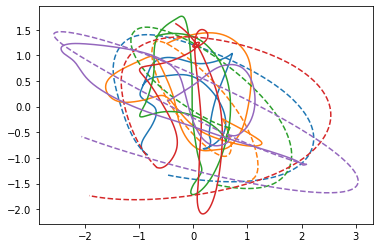

In [106]:
n_steps = 1000
for focal_idx in range(num_individuals):
    plt.plot(
        estimated_traj_numpy[0, focal_idx, :n_steps],
        estimated_traj_numpy[1, focal_idx, :n_steps],
        color='C'+str(focal_idx)
    )
    plt.plot(
        spp_samples[sample_id, 0, focal_idx, :n_steps],
        spp_samples[sample_id, 1, focal_idx, :n_steps],
        color='C'+str(focal_idx), ls='--'
    )

Well that didn't work too well.